# Income Redistribution Model
Author : Kei Ikegami (Department of Economics, University of Tokyo)
  
  
From Miranda and Fackler, Applied Computational Economics and Finance, 2002, Section 8.5.2 and 9.8.2

## 8.5.2 Model formulation

Agents decide how much invest each time and they contract that they redistribute the wealth after maturity.

Agent p's reward is, $u_p(s_p - x_p) = \frac{(s_p - x_p)^{1-\alpha_p}}{1-\alpha_p}$
,where $s_p$ is a predetermined level of wealth and $x_p$ is the amount of investment. So $s_p - x_p$ is the amount of consumption.

Wealth evolution is, $h_p(x_{p, t}, \epsilon_{p,t+1}) = \gamma_p x_{p,t} + \epsilon_{p,t+1} x_{p,t}^{\beta_p}$

Then the realized wealth for agent p at time t+1 is, $s_{p, t+1} = (1 - \psi) h_p(x_{p, t}, \epsilon_{p,t+1}) + \psi h_q(x_{q, t}, \epsilon_{q,t+1})$
,where $\psi$ is the pre-determined wealth share rate between the players.

Consider two players case, each denoted by 1 and 2, who live forever. 

The time independent state transition function is defined as follows.

$g(s_1, s_2, x_1, x_2, \epsilon_1, \epsilon_2) = ((1 - \psi) h_1(x_1, \epsilon_1)+ \psi h_2(x_2, \epsilon_2),\ (1 - \psi) h_2(x_2, \epsilon_2)+ \psi h_1(x_1, \epsilon_1))$

Using the above functions, and defining $V_p$ as the value functions, we can set the system of Bellman equations as follows.

$\begin{cases} V_1(s_1, s_2) = \max_{0\leq x_1\leq s_1} \left\{ u_1(s_1 - x_1) + \delta E_{\epsilon}\left[ V_1(g(s_1, s_2, x_1, x_2, \epsilon_1, \epsilon_2)) \right] \right\}\\[10pt]
V_2(s_1, s_2) = \max_{0\leq x_2\leq s_2} \left\{ u_2(s_2 - x_2) + \delta E_{\epsilon}\left[ V_2(g(s_1, s_2, x_1, x_2, \epsilon_1, \epsilon_2)) \right] \right\}
\end{cases}$

## 9.8.2 Solve the model by collocation method

I solve the above systems of functional equations by using collocation method, which means searching the Markov perfect equilibrium in this model.

In [1]:
using BasisMatrices
using QuantEcon
using PyPlot
using Distributions

In [2]:
# set environment
n = 15
smin = 3
smax = 11
maxit = 10000
# num_nodes is for gaussian quadrature
num_nodes = 3
tol = 0.000000001


# make collocation matrix
sgrid0 = linspace(smin, smax, n)
basis = Basis(SplineParams(sgrid0, 0, 3), SplineParams(sgrid0, 0, 3))
S, (coordx, coordy) = nodes(basis)
Φ = BasisMatrix(basis, Expanded(), S, 0)

BasisMatrix{BasisMatrices.Expanded} of order [0 0]

In [3]:
# set model type
mutable struct IRG
    alpha::Array{Float64,1}
    beta::Array{Float64,1}
    gamma::Array{Float64,1}
    sigma::Array{Float64, 1}
    psi::Float64
    delta::Float64
end

# functions in this model
# vector valued functions
function u(model::IRG, s::Array{Float64, 2}, x::Array{Float64, 2}, p::Int64)
    return ((s[:, p] - x[:, p]).^(1 - model.alpha[p]))./(1 - model.alpha[p])
end

function h(model::IRG, x::Array{Float64, 2}, epsilon::Float64, p::Int64)
    return model.gamma[p] * x[:, p] + epsilon * (x[:, p].^(model.beta[p]))
end

function s(model::IRG, x::Array{Float64, 2}, epsilon::Array{Float64, 1})
    box = zeros((size(x)[1], 2))
    box[:, 1] = (1 - model.psi)*h(model, x, epsilon[1], 1) + model.psi*h(model, x, epsilon[2], 2)
    box[:, 2] = (1 - model.psi)*h(model, x, epsilon[2], 2) + model.psi*h(model, x, epsilon[1], 1)
    return box
end

# derivatives of  payoff, transition functions
# utility function
function ux(model::IRG, s::Array{Float64, 2}, x::Array{Float64, 2}, p::Int64)
    return -(s[:, p] - x[:, p]).^(-model.alpha[p])
end

function uxx(model::IRG, s::Array{Float64, 2}, x::Array{Float64, 2}, p::Int64)
    return -model.alpha[p]*(s[:, p] - x[:, p]).^(-model.alpha[p]-1)
end

# transition function
function sx(model::IRG, x::Array{Float64, 2}, epsilon::Array{Float64, 1},  p::Int64)
    return (1 - model.psi)*(model.gamma[p] + epsilon[p]*model.beta[p]*x[:, p].^(model.beta[p] - 1))
end

function sxx(model::IRG, x::Array{Float64, 2}, epsilon::Array{Float64, 1},  p::Int64)
    return (1 - model.psi)*epsilon[p]*model.beta[p]*(model.beta[p] - 1)*x[:, p].^(model.beta[p] - 2)
end

# Gaussian Quadrature
function gq(model::IRG, num_nodes::Int64)
    return qnwlogn([num_nodes, num_nodes], [0,0], diagm([model.sigma[1]^2, model.sigma[2]^2]))
end

# collocation function
function vmax(model::IRG, colnodes::Array{Float64, 2}, b, coef::Array{Float64, 2}, epss::Array{Float64, 2}, weights::Array{Float64, 1})
    xnew = zeros((size(colnodes)[1], 2))+0.2
    v = zeros((size(colnodes)[1], 2))
    vnew = v
    for p in 1:2
        xl, xu = 0.0, colnodes[:, p]
        order1 = [0 0]
        order1[1, p] = 1
        order2 = [0 0]
        order2[1, p] = 2
        for it in 1:maxit
            util, util_der1, util_der2 = u(model, colnodes, xnew, p), ux(model, colnodes, xnew, p), uxx(model, colnodes, xnew, p)
            #@show typeof(util)
            #@show typeof(util_der1)
            #@show typeof(util_der2)
            Ev, Evx, Evxx = 0.0, 0.0, 0.0
            for k in 1:num_nodes^2
                eps, weight= epss[k, :], weights[k]
                transition, transition_der1, transition_der2 = s(model, xnew, eps), sx(model, xnew, eps, p), sxx(model, xnew, eps, p)
                vn = funeval(coef[:, p], b, transition)
                vnder1 =  funeval(coef[:, p], b, transition, order1)
                vnder2 = funeval(coef[:, p], b, transition, order2)
                #@show typeof(vn)
                #@show typeof(vnder1)
                #@show typeof(vnder2)
                Ev += weight * model.delta*vn
                Evx += weight* vnder1.* transition_der1
                Evxx += weight * (vnder1.*transition_der2 + vnder2 .* (transition_der1.^2))
                #@show typeof(transition)
                #@show typeof(transition_der1)
                #@show typeof(transition_der2)
            end
            v[:, p] = util + Ev
            delx = -(util_der1 + model.delta * Evx) ./ (util_der2 + model.delta*Evxx)
            #@show print(delx)
            delx = min.(max.(delx, xl-xnew[:, p]), xu-xnew[:, p])
            xnew[:, p] = xnew[:, p] + delx
            if norm(delx) < tol
                break
            end
        end
        vnew[:, p] = v[:, p]
    end
    return vnew, xnew
end

vmax (generic function with 1 method)

solve

In [4]:
# set initials
srand(120)
initial = - rand((size(Φ.vals[1])[1]), 2)*10
x = zeros((size(Φ.vals[1])[1]), 2)+2
v = zeros((size(Φ.vals[1])[1]), 2) +2
model = IRG([0.2,0.2], [0.5, 0.5], [0.9,0.9], [0.1,0.1], 0.05, 0.9)
e, w = gq(model, num_nodes)

# iteration for coefficients
c = initial
c_error = c
count = 0
for it in 1:maxit
    cold = c
    vnew, x = vmax(model, S, basis, c, e, w)
    c = Φ.vals[1] \ vnew
    v = vnew
    c_error = cold - c
    count += 1
    if maximum(abs, cold - c) < tol 
        break
    end
end

# println(count)
# println(c_error)


### Policy function

In [8]:
xgrid = zeros((n+2, n+2))
ygrid = zeros((n+2, n+2))
for i in 1:n+2
    xgrid[i, :] = coordx'
end
for i in 1:n+2
    ygrid[:, i] = coordy
end
z = reshape(x[:, 1], n+2, n+2);

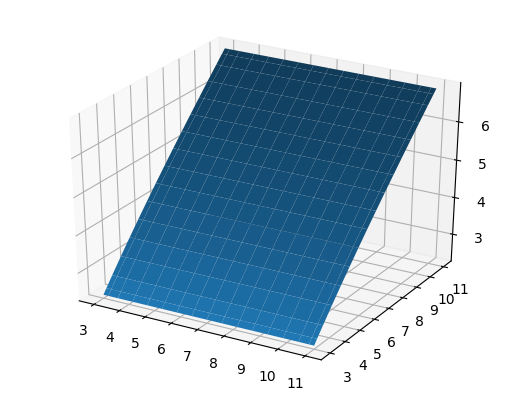

PyObject <mpl_toolkits.mplot3d.art3d.Poly3DCollection object at 0x11c1a4050>

In [9]:
# policy function for player 1
surf(xgrid, ygrid, z)

### Value function

### Residual 

In [15]:
# use vmax on new grid
nn = 30
gri = linspace(smin, smax, nn)
new_grid = gridmake(gri, gri)
v_true = vmax(model, new_grid, basis, c, e, w)[1][:, 1];

In [16]:
# predicted value function
predict_value = funeval(c, basis, new_grid)[:, 1];

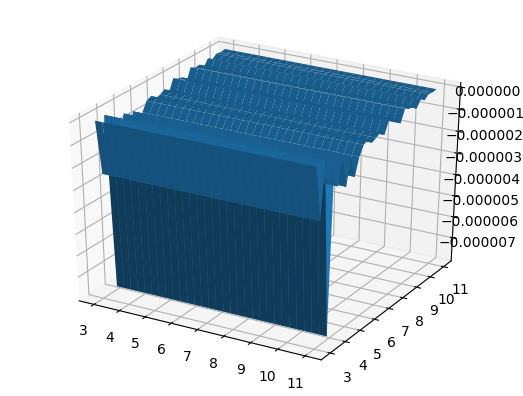

PyObject <mpl_toolkits.mplot3d.art3d.Poly3DCollection object at 0x12bae0190>

In [17]:
resid = reshape(v_true - predict_value, nn, nn)
xgrid = zeros((nn, nn))
ygrid = zeros((nn, nn))
for i in 1:nn
    xgrid[i, :] = Array(gri)'
end
for i in 1:nn
    ygrid[:, i] = Array(gri)
end

surf(xgrid, ygrid, resid)

## Simulation

Now we simulate this model for 20 periods by using the policy function. The below results are the average values over 2000 times simulations.

In [47]:
# initial_value :: 1st value is the initial wealth level of player1, 2nd one is for the other player
# policy :: policy function defined over the wealth distribution space
# times :: simulation times averaged over
# periods :: simulation period
# p :: the player whose result we want to get

function simulate(model::IRG,
    initial_value::Array{Float64, 1},
    b,
    coef_x::Array{Float64, 2},
    times::Int64,
    periods::Int64,
    p::Int64)
    
    srand(12345)
    box = ones((1, 2))
    wealth_p = zeros((periods+1, times))
    investment_p = zeros((periods, times))
    m = LogNormal(0,model.sigma[1]^2)
    
    wealth_transition = zeros((periods+1, 2))
    invest_transition = zeros((periods, 2))
    wealth_transition[1,:] = initial_value
    
    for j in 1:times
        for i in 2:periods+1
            invest = funeval(coef_x, b, [wealth_transition[i-1, 1], wealth_transition[i-1, 2]])
            box[1, :] = invest
            invest_transition[i-1, :] = box
            epsilon = rand(m, 2)
            wealth_transition[i, :] = s(model, box, epsilon)
        end
        wealth_p[:, j] = wealth_transition[:, p]
        investment_p[:, j] = invest_transition[:, p]
    end
    
    return mean(wealth_p, 2), mean(investment_p, 2)
end

simulate (generic function with 1 method)

In [48]:
# basis coefficient for policy function
c_x =Φ.vals[1] \ x
initial = [7.5, 7.5]
periods = 20
times = 2000

wealth_result, invest_result = simulate(model, initial, basis, c_x, times, periods, 1)

([7.5; 6.77313; … ; 5.40537; 5.40499], [5.04154; 4.6349; … ; 3.8466; 3.84654])

### Simulation result

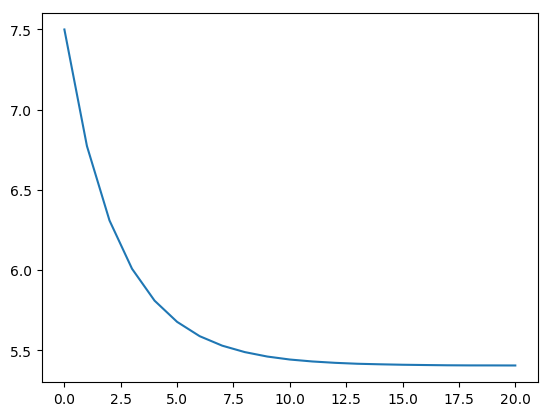

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x12764f150>

In [50]:
plot(wealth_result)

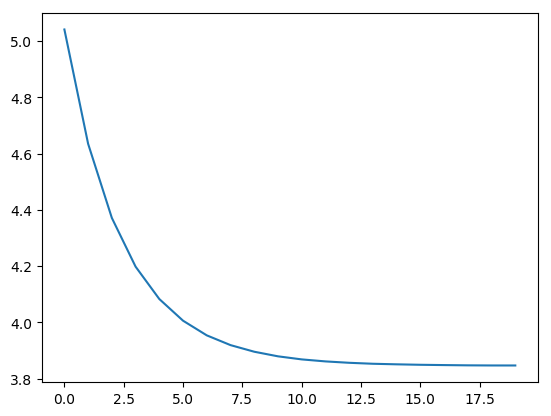

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x12ce474d0>

In [51]:
plot(invest_result)